In [5]:
from datasets import load_dataset
from pprint import pprint
ds = load_dataset("HuggingFaceH4/rlaif-v_formatted",streaming=True)

In [3]:
ds

IterableDatasetDict({
    train: IterableDataset({
        features: ['chosen', 'rejected', 'images', 'prompt'],
        num_shards: 13
    })
    test: IterableDataset({
        features: ['chosen', 'rejected', 'images', 'prompt'],
        num_shards: 1
    })
})

In [6]:
for sample in ds['train'].take(1):
    pprint(sample)

{'chosen': [{'content': [{'text': 'The image showcases a white mobile device '
                                  'with various buttons and a screen, '
                                  'positioned on a stand accompanied by two '
                                  'speakers.',
                          'type': 'text'}],
             'role': 'assistant'}],
 'images': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x7518EA169810>],
 'prompt': [{'content': [{'text': None, 'type': 'image'},
                         {'text': 'Itemize the elements you identify in the '
                                  'image and describe them thoroughly.',
                          'type': 'text'}],
             'role': 'user'}],
 'rejected': [{'content': [{'text': 'The image features a white Qool speaker '
                                    'dock with a silver phone, orange and '
                                    'black buttons, a clear glass case, and a '
                             

In [1]:
# Cell 1: Setup
from datasets import load_dataset
from tokenizers import Tokenizer
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load tokenizer
tokenizer_path = Path("../..") / "visual_instruction_tuning" / "bpe_tokenizer_with_image_tag.json"
tokenizer = Tokenizer.from_file(str(tokenizer_path))
print(f"Vocab size: {tokenizer.get_vocab_size()}")

# Load dataset
print("Loading RLAIF-V dataset...")
ds = load_dataset("openbmb/RLAIF-V-Dataset")
print(f"Total samples: {len(ds['train']):,}")


Vocab size: 32001
Loading RLAIF-V dataset...


README.md: 0.00B [00:00, ?B/s]

RLAIF-V-Dataset_000.parquet:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

RLAIF-V-Dataset_001.parquet:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

RLAIF-V-Dataset_002.parquet:   0%|          | 0.00/970M [00:00<?, ?B/s]

RLAIF-V-Dataset_003.parquet:   0%|          | 0.00/971M [00:00<?, ?B/s]

RLAIF-V-Dataset_004.parquet:   0%|          | 0.00/856M [00:00<?, ?B/s]

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: d67e63ea-30fc-4454-a2bc-ec8408538c2a)')' thrown while requesting HEAD https://huggingface.co/datasets/openbmb/RLAIF-V-Dataset/resolve/cdfc8c13778434e38afd538b0641ea942df4af78/RLAIF-V-Dataset_005.parquet
Retrying in 1s [Retry 1/5].


RLAIF-V-Dataset_005.parquet:   0%|          | 0.00/755M [00:00<?, ?B/s]

RLAIF-V-Dataset_006.parquet:   0%|          | 0.00/897M [00:00<?, ?B/s]

RLAIF-V-Dataset_007.parquet:   0%|          | 0.00/868M [00:00<?, ?B/s]

RLAIF-V-Dataset_008.parquet:   0%|          | 0.00/1.00G [00:00<?, ?B/s]

RLAIF-V-Dataset_009.parquet:   0%|          | 0.00/828M [00:00<?, ?B/s]

RLAIF-V-Dataset_010.parquet:   0%|          | 0.00/962M [00:00<?, ?B/s]

RLAIF-V-Dataset_011.parquet:   0%|          | 0.00/853M [00:00<?, ?B/s]

RLAIF-V-Dataset_012.parquet:   0%|          | 0.00/826M [00:00<?, ?B/s]

RLAIF-V-Dataset_013.parquet:   0%|          | 0.00/726M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Total samples: 83,132


In [2]:
# Cell 2: Analyze 50K samples
NUM_SAMPLES = 50000

chosen_lengths = []
rejected_lengths = []
full_chosen_lengths = []  # With prompt
full_rejected_lengths = []

for i, sample in enumerate(tqdm(ds['train'], total=NUM_SAMPLES)):
    if i >= NUM_SAMPLES:
        break
    
    question = sample['question']
    chosen = sample['chosen']
    rejected = sample['rejected']
    
    # Format like training
    prompt = f" USER: {question} ASSISTANT:"
    chosen_full = f" USER: {question} ASSISTANT: {chosen}"
    rejected_full = f" USER: {question} ASSISTANT: {rejected}"
    
    # Tokenize
    prompt_len = len(tokenizer.encode(prompt).ids)
    chosen_len = len(tokenizer.encode(chosen).ids)
    rejected_len = len(tokenizer.encode(rejected).ids)
    full_chosen_len = len(tokenizer.encode(chosen_full).ids) + 2  # +2 for <image> and </s>
    full_rejected_len = len(tokenizer.encode(rejected_full).ids) + 2
    
    chosen_lengths.append(chosen_len)
    rejected_lengths.append(rejected_len)
    full_chosen_lengths.append(full_chosen_len)
    full_rejected_lengths.append(full_rejected_len)

chosen_lengths = np.array(chosen_lengths)
rejected_lengths = np.array(rejected_lengths)
full_chosen_lengths = np.array(full_chosen_lengths)
full_rejected_lengths = np.array(full_rejected_lengths)


100%|██████████| 50000/50000 [01:32<00:00, 542.29it/s]


In [3]:
# Cell 3: Statistics
print("=" * 60)
print("RESPONSE ONLY (chosen/rejected text)")
print("=" * 60)
print(f"Chosen:   min={chosen_lengths.min()}, max={chosen_lengths.max()}, mean={chosen_lengths.mean():.1f}, 95th={np.percentile(chosen_lengths, 95):.0f}, 99th={np.percentile(chosen_lengths, 99):.0f}")
print(f"Rejected: min={rejected_lengths.min()}, max={rejected_lengths.max()}, mean={rejected_lengths.mean():.1f}, 95th={np.percentile(rejected_lengths, 95):.0f}, 99th={np.percentile(rejected_lengths, 99):.0f}")

print("\n" + "=" * 60)
print("FULL SEQUENCE (<image> + USER + ASSISTANT + </s>)")
print("=" * 60)
print(f"Chosen:   min={full_chosen_lengths.min()}, max={full_chosen_lengths.max()}, mean={full_chosen_lengths.mean():.1f}, 95th={np.percentile(full_chosen_lengths, 95):.0f}, 99th={np.percentile(full_chosen_lengths, 99):.0f}")
print(f"Rejected: min={full_rejected_lengths.min()}, max={full_rejected_lengths.max()}, mean={full_rejected_lengths.mean():.1f}, 95th={np.percentile(full_rejected_lengths, 95):.0f}, 99th={np.percentile(full_rejected_lengths, 99):.0f}")

# Recommendation
max_len = max(full_chosen_lengths.max(), full_rejected_lengths.max())
p99 = max(np.percentile(full_chosen_lengths, 99), np.percentile(full_rejected_lengths, 99))
print(f"\n→ Recommended max_seq_len: {int(p99) + 10} (covers 99% of samples)")
print(f"→ To cover ALL samples: {max_len}")


RESPONSE ONLY (chosen/rejected text)
Chosen:   min=1, max=522, mean=76.0, 95th=178, 99th=243
Rejected: min=1, max=513, mean=76.2, 95th=177, 99th=243

FULL SEQUENCE (<image> + USER + ASSISTANT + </s>)
Chosen:   min=18, max=540, mean=98.5, 95th=202, 99th=267
Rejected: min=17, max=533, mean=98.7, 95th=202, 99th=267

→ Recommended max_seq_len: 277 (covers 99% of samples)
→ To cover ALL samples: 540


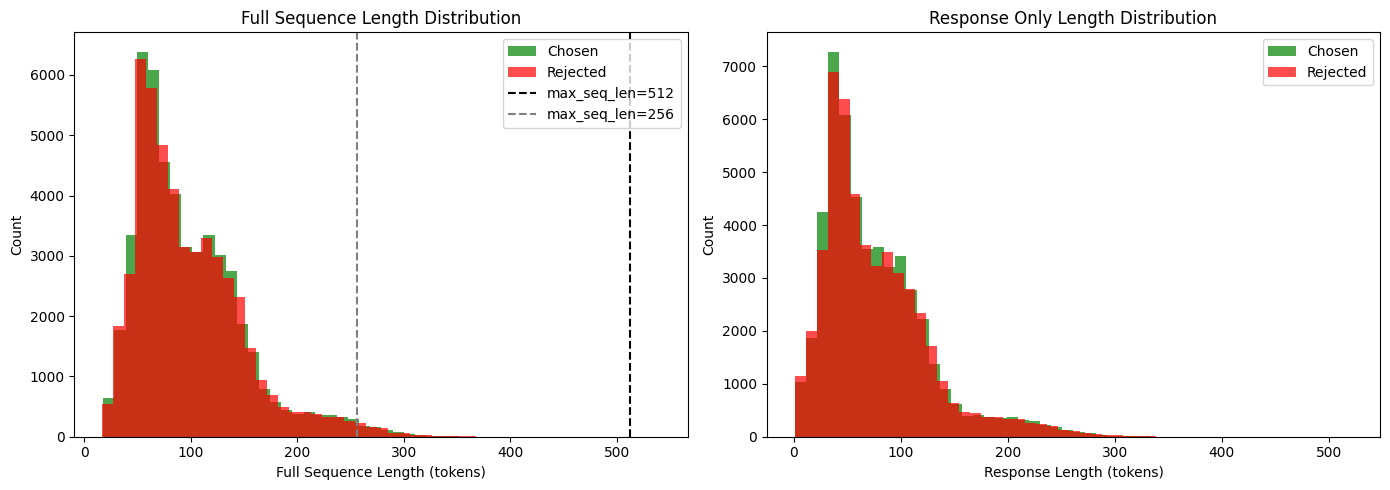

max_seq_len=256: 1,152 samples truncated (2.30%)
max_seq_len=384: 9 samples truncated (0.02%)
max_seq_len=512: 5 samples truncated (0.01%)
max_seq_len=768: 0 samples truncated (0.00%)


In [4]:
# Cell 4: Histogram
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(full_chosen_lengths, bins=50, alpha=0.7, label='Chosen', color='green')
axes[0].hist(full_rejected_lengths, bins=50, alpha=0.7, label='Rejected', color='red')
axes[0].axvline(x=512, color='black', linestyle='--', label='max_seq_len=512')
axes[0].axvline(x=256, color='gray', linestyle='--', label='max_seq_len=256')
axes[0].set_xlabel('Full Sequence Length (tokens)')
axes[0].set_ylabel('Count')
axes[0].set_title('Full Sequence Length Distribution')
axes[0].legend()

axes[1].hist(chosen_lengths, bins=50, alpha=0.7, label='Chosen', color='green')
axes[1].hist(rejected_lengths, bins=50, alpha=0.7, label='Rejected', color='red')
axes[1].set_xlabel('Response Length (tokens)')
axes[1].set_ylabel('Count')
axes[1].set_title('Response Only Length Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()

# How many would be truncated at different max_seq_len values
for max_len in [256, 384, 512, 768]:
    truncated = ((full_chosen_lengths > max_len) | (full_rejected_lengths > max_len)).sum()
    pct = 100 * truncated / len(full_chosen_lengths)
    print(f"max_seq_len={max_len}: {truncated:,} samples truncated ({pct:.2f}%)")
